In [1]:
#Analysis of time-series data for two stars with transiting exoplanets, observed by NASA’s Transiting Exoplanet Survey Satellite (TESS) (Astrophysics & Astronomy programming project)
#David Mathas  

#imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle

In [128]:
#loading in data:
def load_tess_data(file_name: str) -> np.ndarray:
    """Load TESS data from a file and return it as a NumPy array.

    Parameters: file_name: str: The name of the TESS data file to be loaded.

    Returns: np.ndarray: A NumPy array containing the imported TESS data.

    This function reads TESS data from a file and returns it as a NumPy array.

    Example:
    >>> data = load_tess_data('tess_lc1.dat')"""

    tess_data = np.genfromtxt(file_name)
    print('Loaded in, shape of raw imported data:', tess_data.shape)

    return tess_data


#cleaning in data 
def clean_tess_data(tess_data: np.ndarray) -> np.ndarray:
    """Clean TESS data by removing rows with NaN values.

    Parameters: tess_data: np.ndarray: The raw TESS data as a NumPy array.

    Returns: np.ndarray: A NumPy array containing cleaned TESS data.

    This function takes raw TESS data as input and performs the following steps:
    1. Removes rows with NaN values.
    2. Returns a cleaned version of the TESS data as a NumPy array.

    Example:
    >>> cleaned_data = clean_tess_data(raw_data)"""

    print('Cleaning data...')
    #rows with non-NaN values:
    valid_rows = ~np.any(np.isnan(tess_data), axis=1)

    #subsetting:
    tess_cleaned_data = tess_data[valid_rows]
    print('Number of removed NaN-values:', len(tess_data) - len(tess_cleaned_data))
    days = tess_cleaned_data[:, 0]
    flux_unsmoothed = tess_cleaned_data[:, 1]
    print('Data cleaned.')

    return days, flux_unsmoothed


#plotting the data:
def plot_tess_data(tess_days: np.ndarray, tess_flux_unsmoothed: np.ndarray, dataset_nr: int):
    """Plot unsmoothed TESS data.

    Parameters:
        tess_days: np.ndarray: An array of time values (days).
        tess_flux_unsmoothed: np.ndarray: An array of unsmoothed flux values.
        dataset_nr: int: The dataset number.

    This function plots the unsmoothed TESS data with the provided time values and flux values.
    It customizes the plot based on the dataset number.

    Example:
    >>> plot_tess_data(days, flux, 1)"""

    plt.plot(tess_days, tess_flux_unsmoothed, label='Tess Data', color='k', linewidth=0.4)
    plt.title(f'TESS Exoplanet Transit Light Curve (unsmoothed) for dataset {dataset_nr}', fontsize=14)
    plt.xlabel('Time (days)', fontsize=12)
    plt.ylabel('Calibrated Photoelectron Count Rates (electrons/s)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

#smoothing function:
def smooth_lightcurve(unsmoothed_data: np.ndarray, window_size: int = 5) -> list:
    
    """
    Smooths a given unsmoothed lightcurve using a rolling average window.

    Parameters: unsmoothed_data: np.ndarray: The unsmoothed lightcurve data as a NumPy array.
                window_size: int, optional: The size of the rolling average window. Default is 5.

    Returns: list: A list containing the smoothed lightcurve data.

    The function calculates the rolling average for each data point in the unsmoothed lightcurve
    using a window that can be specified size. For the first and last few data points, where the
    rolling window extends beyond the data, it calculates the average using the available data
    points.

    Example:
        >>> unsmoothed_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
        >>> smoothed_data = smooth_lightcurve(unsmoothed_data, window_size=3)
        >>> print(smoothed_data)
        [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 8.666666666666666, 9.333333333333334, 10.0]
        """
    
    smoothed_data = np.convolve(unsmoothed_data, np.ones(window_size), 'valid') / window_size

    return smoothed_data


#Plot for smoothed cleaned TESS data:
def plot_smoothed_cleaned_data(days: np.ndarray, smoothed_flux: np.ndarray,  dataset_nr: int):
    """
    Plot smoothed and cleaned TESS data.

    Parameters: days: np.ndarray: An array of time values (days).
                unsmoothed_flux: np.ndarray: An array of unsmoothed flux values.
                dataset_nr: int: The dataset number.
                
    This function creates a plot with two subplots to visualize smoothed and cleaned TESS data:
    - The upper subplot displays the entire light curve.
    - The lower subplot zooms in on a specific segment of the light curve.
    """

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})
    
    #adjust the length of days to the decreased length of smoothed flux:
    len_diff_index = int((len(days) - len(smoothed_flux)) / 2)

    #Plot the entire light curve in the upper subplot
    axs[0].plot(days[len_diff_index : -len_diff_index], smoothed_flux, label='Tess Data', color='k', linewidth=0.4)
    axs[0].set_title(f'TESS Exoplanet Transit Light Curve (smoothed) for dataset {dataset_nr}', fontsize=16)
    axs[0].set_ylabel('Calibrated Photoelectron Count Rates (electrons/s)', fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.7)

    #Plot the zoomed-in segment in the lower subplot
    axs[1].plot(days[len_diff_index : -len_diff_index], smoothed_flux, label='Tess Data', color='b', linewidth=0.8)
    axs[1].set_xlabel('Time (days)', fontsize=12)
    axs[1].set_title(f'TESS Exoplanet Transit Light Curve Eclipse (smoothed) for dataset {dataset_nr}', fontsize=16)
    axs[1].set_ylabel('', fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.7)

    #Set x-axis limits for the lower subplot to show the zoomed-in segment:
    min_flux_index = np.argmin(smoothed_flux)
    corresponding_day = days[min_flux_index]
    zoom_start_time = corresponding_day - 1  #the start time of the eclipse
    zoom_end_time = corresponding_day + 1    #end time of the eclipse
    axs[1].set_xlim(zoom_start_time, zoom_end_time)

    plt.tight_layout()
    plt.show()


##LOMB-SCARGLE PERIODOGRAM:
def lomb_scargle_perio(days: np.ndarray, 
                       unsmoothed_flux: np.ndarray, 
                       min_freq: float, 
                       max_freq: float):
    """
    Compute and plot the Lomb-Scargle periodogram to find the orbital period.

    Parameters: days: np.ndarray: An array of time values (days).
                unsmoothed_flux: np.ndarray: An array of unsmoothed flux values.
                min_freq: float: Minimum frequency for the periodogram.
                max_freq: float: Maximum frequency for the periodogram.

    The minimum and maximum frequency are based on visual inspection of the flux curves.

    This function computes the Lomb-Scargle periodogram to analyze the time series data and
    determine the most likely orbital period. It then plots the periodogram and marks the
    best period with a red marker on the plot.
    """
    
    #Compute the Lomb-Scargle periodogram:
    frequency, power = LombScargle(days, unsmoothed_flux).autopower(minimum_frequency = min_freq, maximum_frequency = max_freq)
    best_period = frequency[np.argmax(power)]
    #print period corresponding to the highest peak in the periodogram:
    print("Most likely orbital period:", 1 / best_period, "days") #f = 1 / T

    #PLot it:
    plt.figure(figsize=(10, 6))
    plt.plot(1 / frequency, power, color='k', linewidth=0.8)  #Convert frequency to period: f = 1 / T
    plt.scatter(1 / best_period, np.max(power), color='red', marker='o', label='Best period') #location highest peak
    plt.title('Lomb-Scargle Periodogram', fontsize=16)
    plt.xlabel('Period (days)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.show()


def eclipse_function(time: np.ndarray, 
                     fstar: float, 
                     max_depth: float, 
                     t_cent: float, 
                     ecl_duration: float, 
                     dt_ingress: float):
    
    """Generate a simulated eclipse lightcurve.

    Parameters:
        time: np.ndarray: An array of time values.
        fstar: float: flux level of star when not eclipsed.
        max_depth: float: The maximum depth of the eclipse.
        t_cent: float: The central time of the eclipse.
        ecl_duration: float: The duration of the eclipse.
        dt_ingres: float: The duration of the ingress and egress phases.

    Returns: np.ndarray: An array representing the synthetic eclipse lightcurve.

    This function simulates an eclipse lightcurve based on the given parameters.
    It creates a numpy array of the same length as the input time array and fills it with
    flux values representing the eclipse. The eclipse has a maximum depth specified by
    'max_depth' and occurs at 't_cent'. The 'ecl_duration' parameter determines the
    total duration of the eclipse, and 'dt_ingress' controls the duration of the ingress
    and egress phases, which are assumed to be the same.
    """

    flux_arr = np.ones_like(time) * fstar

    slope = max_depth / dt_ingress

    #declare time indices:
    dt_in = (time > t_cent - ecl_duration / 2) & (time < t_cent - ecl_duration / 2 + dt_ingress)
    t_flat = (time >= t_cent - ecl_duration / 2 + dt_ingress) & (time <= t_cent + ecl_duration / 2 - dt_ingress)
    dt_eg = (time > t_cent + ecl_duration / 2 - dt_ingress) & (time < t_cent + ecl_duration / 2)

    #subset the data 
    flux_arr[dt_in] -= slope * (time[dt_in] - (t_cent - ecl_duration / 2))
    flux_arr[t_flat] = fstar - max_depth
    flux_arr[dt_eg] = (fstar - max_depth) + slope * (time[dt_eg] - (t_cent + ecl_duration / 2 - dt_ingress))

    return flux_arr


def fit_eclipse(days: np.ndarray, 
                unsmoothed_flux: np.ndarray, 
                t_start: float, 
                t_end: float, 
                eclipse_fn = eclipse_function, 
                max_depth_guess_type: int = 1) -> tuple:
    """
    Fit an eclipse model to a subset of data within a specified time range and visualize the fit.

    Parameters: days: np.ndarray: An array of time values (days).
        unsmoothed_flux: np.ndarray: An array of unsmoothed flux values.
        t_star: float: The start time for the subset of data.
        t_end: float: The end time for the subset of data.
        eclipse_fn (callable): The eclipse function used for fitting (default: eclipse_function).
        max_depth_guess: int: 1 for using the difference between the maximum and minimum of the flux, 2 for using a fixed value of 550. 


    Returns: tuple: The zoomed-in days, zoomed-in flux and, most importantly, the fitted flux. 
               
    This function fits an eclipse model to a subset of time series data specified by the time range
    [t_start, t_end]. It uses curve fitting to estimate the parameters of the eclipse model. The fitted parameters are printed
    to the console.

    The initial parameter guesses for curve fitting are automatically determined based on the subset
    of data. You can optionally provide a custom eclipse function by passing it as the 'eclipse_fn'
    parameter.
    """

    #subset the days and flux arrays:
    zoom_idx = np.where((days >= t_start) & (days <= t_end))[0]
    days_zoom = days[zoom_idx]
    flux_zoom = unsmoothed_flux[zoom_idx]
    assert days_zoom.shape == flux_zoom.shape

    #initialization parameters for curve fitting
    if max_depth_guess_type == 1:
        max_depth_guess = np.max(flux_zoom) - np.min(flux_zoom)
    if max_depth_guess_type == 2:
        max_depth_guess = 550.
    fstar_guess = np.mean(flux_zoom)
    t_cent_guess = np.mean(days_zoom)
    ecl_dur_guess = (np.max(days_zoom) - np.mean(days_zoom)) / 2
    dt_ingress_guess = ecl_dur_guess / 4
    initial_guess = [fstar_guess, max_depth_guess, t_cent_guess, ecl_dur_guess, dt_ingress_guess]

    #curve fit:
    params, covariance = curve_fit(eclipse_fn, days_zoom, flux_zoom, p0=initial_guess)

    #get the fitted flux:
    fitted_flux = eclipse_fn(days_zoom, *params)

    #Print fitted parameters:
    print("Fitted Parameters:")
    print("fstar:", params[0], 'electrons/s')
    print("max_depth:", params[1], 'electrons/s')
    print("t_cent: Day", params[2], '(Barycentred Julian Date - 2457000)')
    print("ecl_duration:", params[3], 'days (Barycentred Julian Date - 2457000)')
    print("dt_ingress:", params[4], 'days (Barycentred Julian Date - 2457000)')

    return days_zoom, flux_zoom, fitted_flux


def plot_data_and_fitted_model(days_zoom: np.ndarray, flux_zoom: np.ndarray, fitted_flux: np.ndarray, dataset_nr: int):
    """
    Plot the data and the fitted model.

    Parameters:
        days_zoom: np.ndarray: An array of time values.
        flux_zoom: np.ndarray: An array of flux values.
        fitted_flux: np.ndarray: An array of the fitted model.
        dataset_nr: int: The dataset number.

    Returns:
        None
    """

    plt.figure(figsize=(8, 5))
    plt.scatter(days_zoom, flux_zoom, label='Data', color='k', alpha=0.2)
    plt.plot(days_zoom, fitted_flux, label='Fitted Model', color='r', linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.title(f'Fitting an Eclipse Model to Dataset {dataset_nr}')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.show()


########### 
 DATASET 1
Loaded in, shape of raw imported data: (20076, 2)
Cleaning data...
Number of removed NaN-values: 1982
Data cleaned.


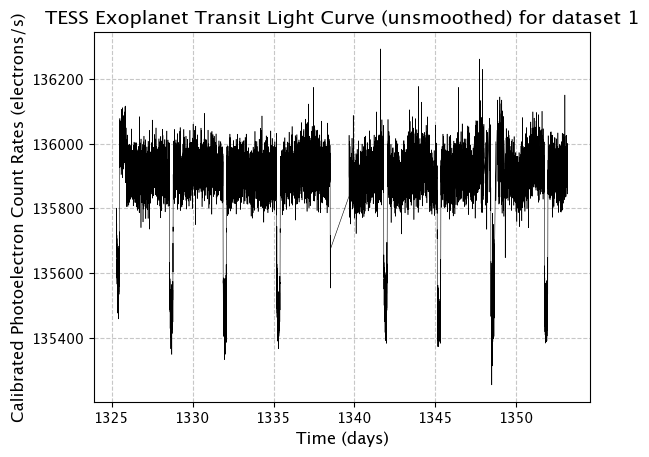

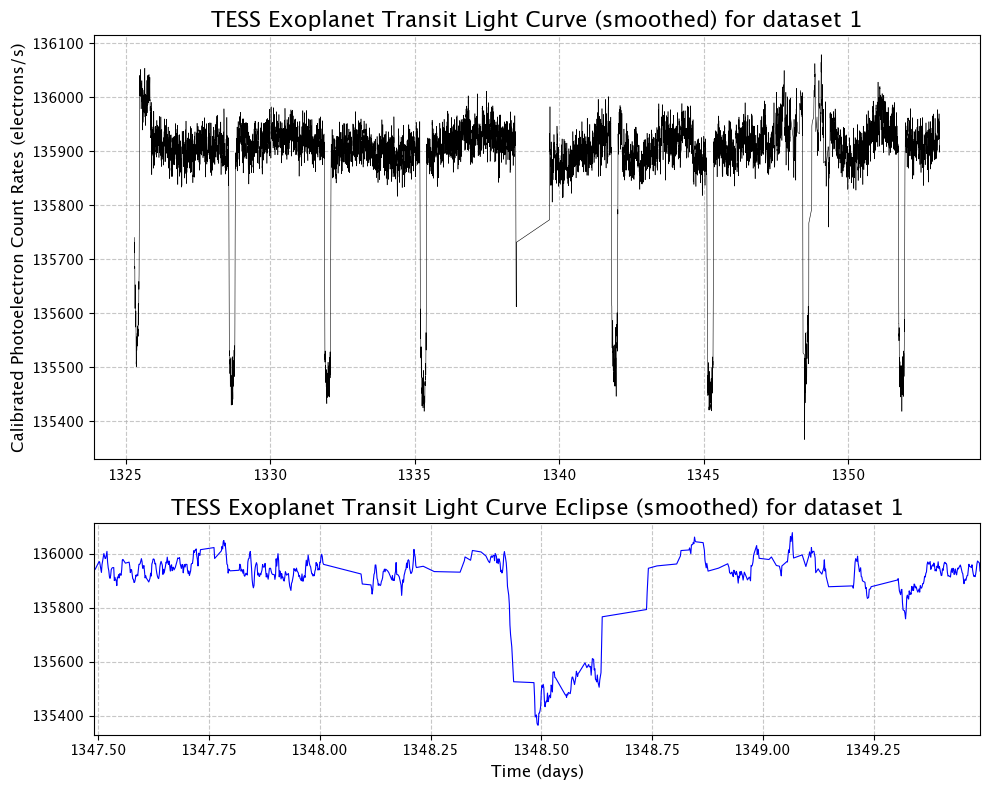

----------------------- 

Most likely orbital period: 3.3800470530508213 days


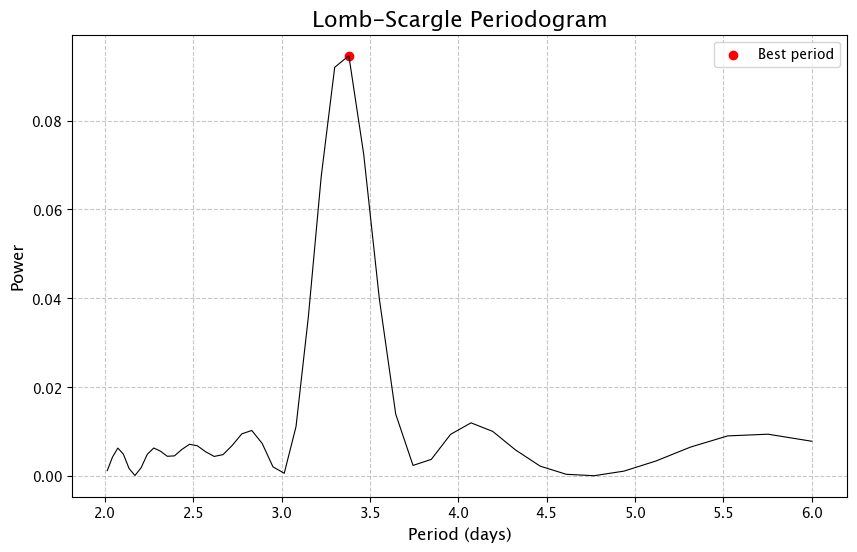

----------------------- 

Eclipse 1:
Fitted Parameters:
fstar: 135911.28019761934 electrons/s
max_depth: 439.24597812372434 electrons/s
t_cent: Day 1335.3031539224967 (Barycentred Julian Date - 2457000)
ecl_duration: 0.24273343255409677 days (Barycentred Julian Date - 2457000)
dt_ingress: 0.03376249230511353 days (Barycentred Julian Date - 2457000)


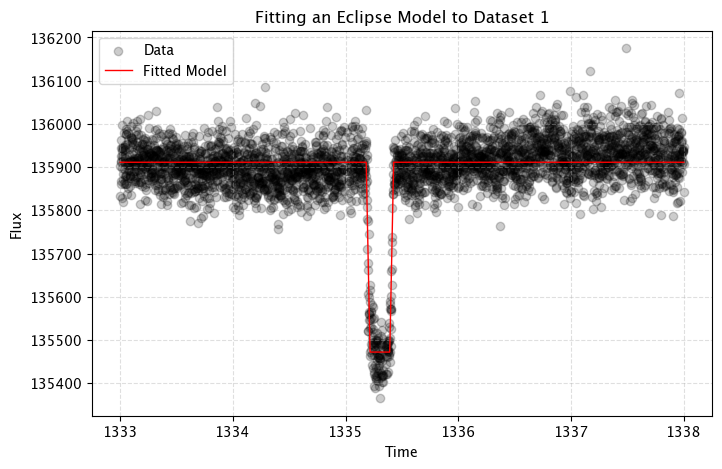

----------------------- 

Eclipse 2:
Fitted Parameters:
fstar: 135911.35949935732 electrons/s
max_depth: 429.5438669637994 electrons/s
t_cent: Day 1331.991845109391 (Barycentred Julian Date - 2457000)
ecl_duration: 0.23588449650817703 days (Barycentred Julian Date - 2457000)
dt_ingress: 0.02398261976572285 days (Barycentred Julian Date - 2457000)


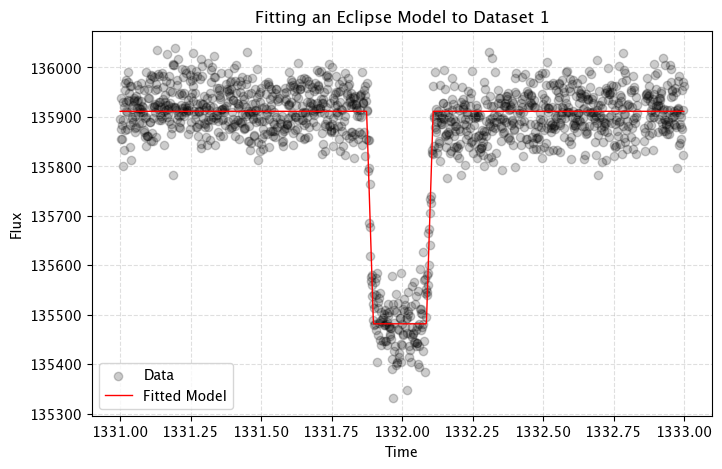

----------------------- 

Eclipse 3:
Fitted Parameters:
fstar: 135926.71578185947 electrons/s
max_depth: 438.0846363370946 electrons/s
t_cent: Day 1351.846984847675 (Barycentred Julian Date - 2457000)
ecl_duration: 0.2419380579765515 days (Barycentred Julian Date - 2457000)
dt_ingress: 0.029509971503850325 days (Barycentred Julian Date - 2457000)


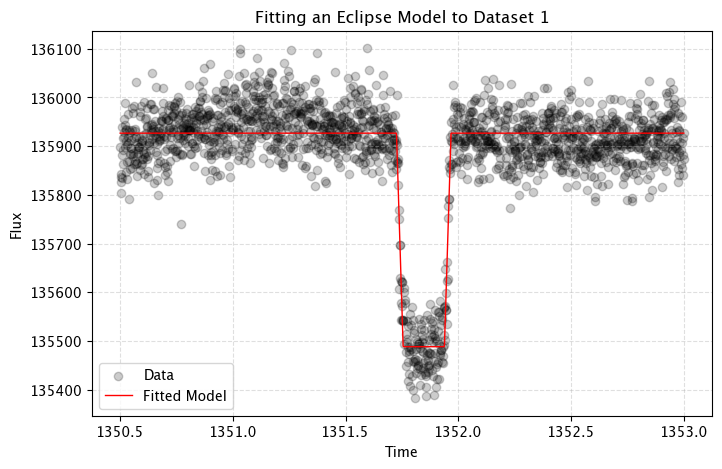

----------------------- 

########### 
 DATASET 2
Loaded in, shape of raw imported data: (20076, 2)
Cleaning data...
Number of removed NaN-values: 1973
Data cleaned.


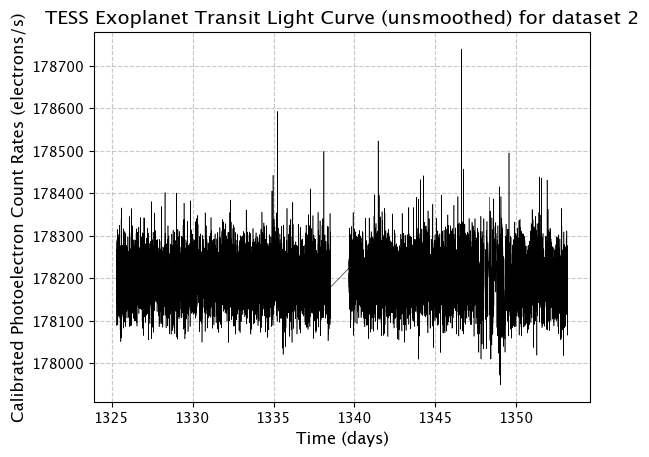

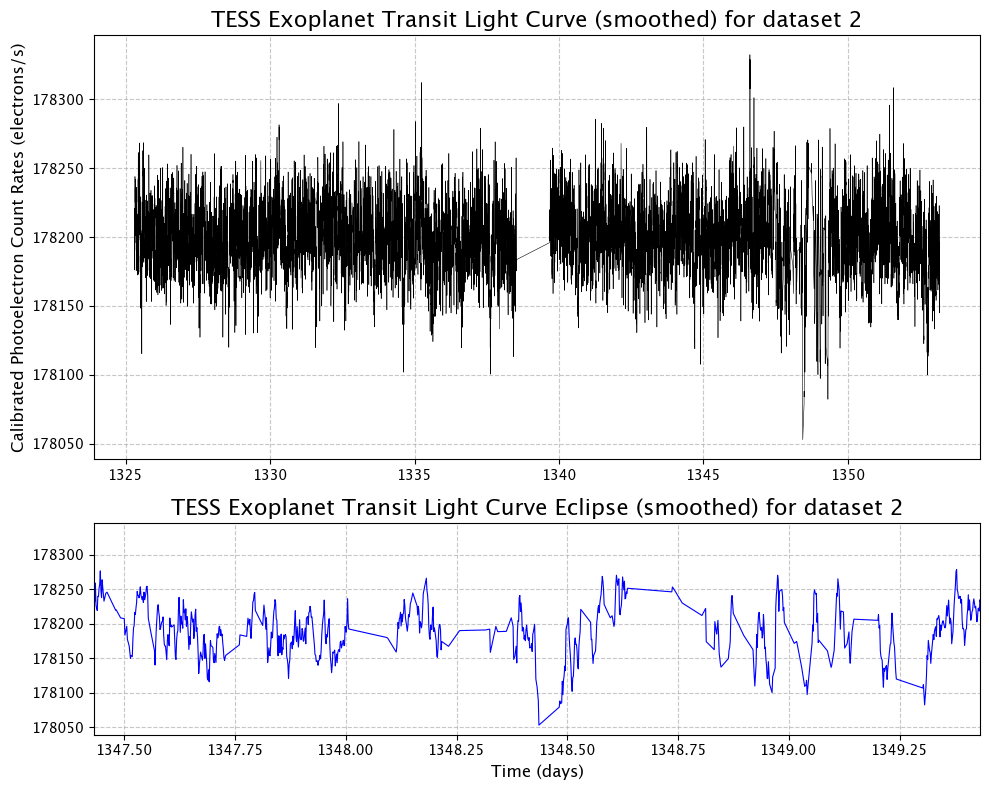

----------------------- 

Most likely orbital period: 1.006138697733909 days


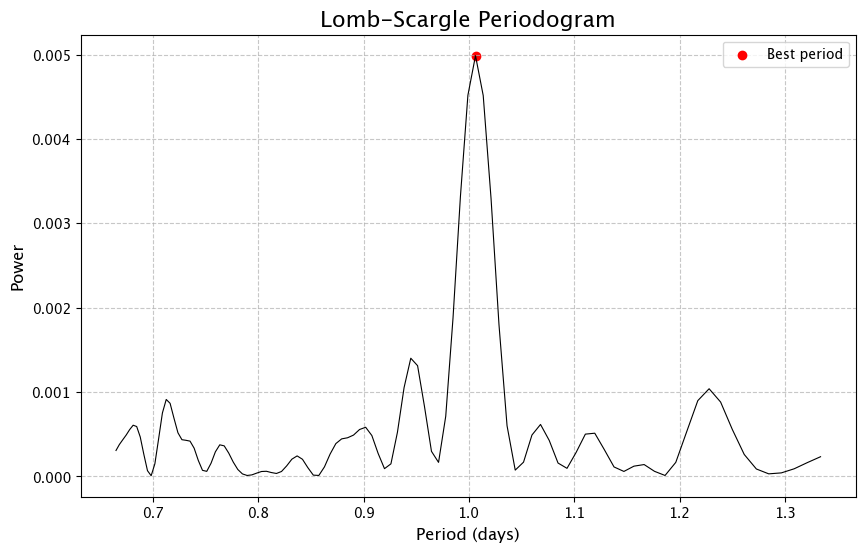

----------------------- 

----------------------- 

Eclipse 1:
Fitted Parameters:
fstar: 178189.6572781347 electrons/s
max_depth: 66.00266972699785 electrons/s
t_cent: Day 1352.751370338598 (Barycentred Julian Date - 2457000)
ecl_duration: 0.07706348242453412 days (Barycentred Julian Date - 2457000)
dt_ingress: 0.027782174169564536 days (Barycentred Julian Date - 2457000)


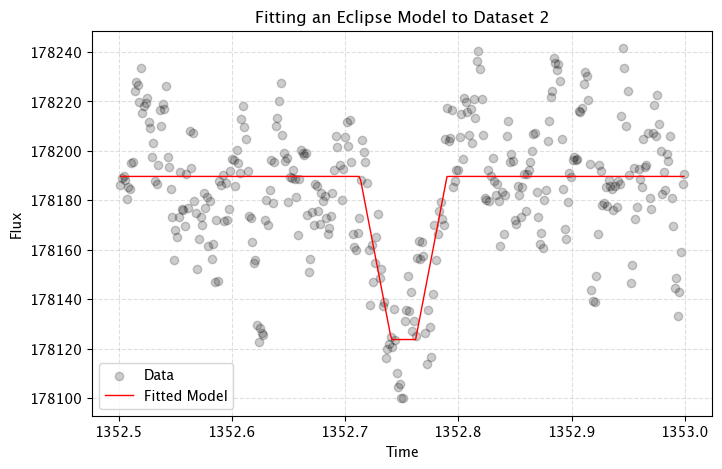

----------------------- 

Eclipse 2:
Fitted Parameters:
fstar: 178211.2235572029 electrons/s
max_depth: 40.614873946092374 electrons/s
t_cent: Day 1351.7121939749127 (Barycentred Julian Date - 2457000)
ecl_duration: 0.17829547070747057 days (Barycentred Julian Date - 2457000)
dt_ingress: 0.056467650652756406 days (Barycentred Julian Date - 2457000)


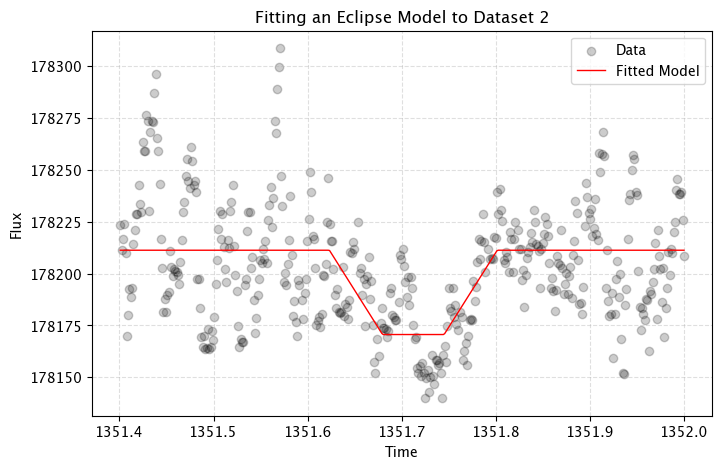

----------------------- 

Eclipse 3:
Fitted Parameters:
fstar: 178205.65536899195 electrons/s
max_depth: 32.694587215538924 electrons/s
t_cent: Day 1350.7523364693973 (Barycentred Julian Date - 2457000)
ecl_duration: 0.16391298944857208 days (Barycentred Julian Date - 2457000)
dt_ingress: 0.039013418771443396 days (Barycentred Julian Date - 2457000)


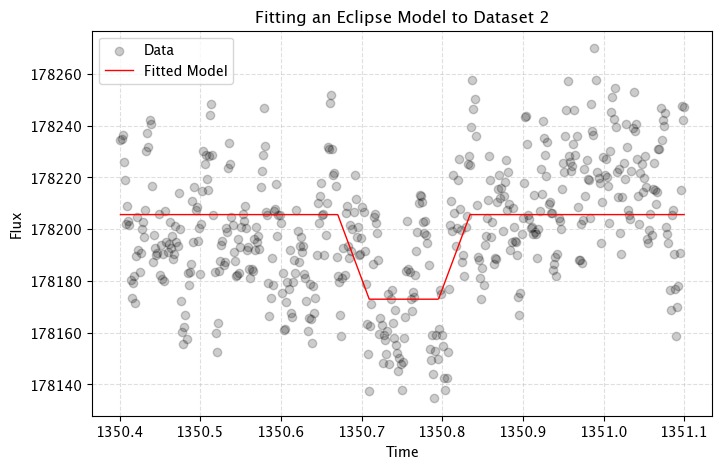

----------------------- 



In [129]:
#MAIN:

###########
#DATASET 1:
print('########### \n DATASET 1')
TESS_DATA_1 = load_tess_data('tess_lc1.dat')
DAYS_1, FLUX_UNSMOOTHED_1 = clean_tess_data(TESS_DATA_1)
plot_tess_data(DAYS_1, FLUX_UNSMOOTHED_1, 1)

FLUX_SMOOTHED_1 = smooth_lightcurve(FLUX_UNSMOOTHED_1)

#plots of smoothed cleaned data and lomb_scargle periodogram:
plot_smoothed_cleaned_data(DAYS_1, FLUX_SMOOTHED_1, 1)
print('----------------------- \n')

min_freq_1 = 1.0 / 6.0
max_freq_1 = 0.5
lomb_scargle_perio(DAYS_1, FLUX_UNSMOOTHED_1, min_freq_1, max_freq_1)
print('----------------------- \n')

#optimizations:
print('Eclipse 1:')
zoom_fit_1a = fit_eclipse(DAYS_1, FLUX_UNSMOOTHED_1, 1333., 1338.,  max_depth_guess_type=2)
plot_data_and_fitted_model(*zoom_fit_1a, 1)
print('----------------------- \n')

print('Eclipse 2:')
zoom_fit_1b = fit_eclipse(DAYS_1, FLUX_UNSMOOTHED_1, 1331., 1333.)
plot_data_and_fitted_model(*zoom_fit_1b, 1)
print('----------------------- \n')

print('Eclipse 3:')
zoom_fit_1c = fit_eclipse(DAYS_1, FLUX_UNSMOOTHED_1, 1350.5, 1353.)
plot_data_and_fitted_model(*zoom_fit_1c, 1)
print('----------------------- \n')
###########


###########
#DATASET 2:
print('########### \n DATASET 2')
TESS_DATA_2 = load_tess_data('tess_lc2.dat')
DAYS_2, FLUX_UNSMOOTHED_2 = clean_tess_data(TESS_DATA_2)
plot_tess_data(DAYS_2, FLUX_UNSMOOTHED_2, 2)

FLUX_SMOOTHED_2 = smooth_lightcurve(FLUX_UNSMOOTHED_2)

#plots of smoothed cleaned data and lomb_scargle periodogram:
plot_smoothed_cleaned_data(DAYS_2, FLUX_SMOOTHED_2, 2)
print('----------------------- \n')

min_freq_2 = 0.75
max_freq_2 = 1.5
lomb_scargle_perio(DAYS_2, FLUX_UNSMOOTHED_2, min_freq_2, max_freq_2)
print('----------------------- \n')


#optimizations:
#used smoothed flux here.
print('Eclipse 1:')
zoom_fit_2a = fit_eclipse(DAYS_2, FLUX_SMOOTHED_2, 1352.5, 1353.)
plot_data_and_fitted_model(*zoom_fit_2a, 2)
print('----------------------- \n')

print('Eclipse 2:')
zoom_fit_2b = fit_eclipse(DAYS_2, FLUX_SMOOTHED_2, 1351.4, 1352.)
plot_data_and_fitted_model(*zoom_fit_2b, 2)
print('----------------------- \n')

print('Eclipse 3:')
zoom_fit_2c = fit_eclipse(DAYS_2, FLUX_SMOOTHED_2, 1350.4, 1351.1)
plot_data_and_fitted_model(*zoom_fit_2c, 2)
print('----------------------- \n')
###########